# Lab 1
### Alexander Evdokimov, Group 7, Variant 21

1. Develop an algorithm to simulate a given discrete random variable and implement it programmatically.

$$
P\{\xi = k\} = \frac{(k + 1)(k + 2)(k + 3)}{6} \, p^4 (1 - p)^k, \quad k = 0, 1, \dots
$$

The random variable $\xi$ follows a **negative binomial distribution** *$\overline{B_i}(r=4, p)$*.

The negative binomial distribution describes the number of failures preceding the r-th success in a sequence of independent trials with success probability \(p\).

**Theorem:** If $\xi_1, ..., \xi_r$ are independent random variables with geometric distribution *G(p)*, then the sum $\sum_{j=1}^{r} \xi_j$ has a negative binomial distribution *$\overline{B_i}(r, p)$*.

Thus, the simulation algorithm for $\xi$ is:

Step 1. Generate $\xi_1, ..., \xi_r$ with geometric distribution *G(p)*.  

Step 2. Calculate $\xi = \xi_1 + ... + \xi_r$.  

In [17]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import chi2

For generating random variables $\xi_1, ..., \xi_r$ with geometric distribution, we use the formula:

$$\xi = \left\lfloor \frac{\ln{\alpha}}{\ln{1-p}} \right\rfloor$$

In [18]:
# Geometric random variable generator
def geometric(p):
    a = np.random.rand()
    k = int(math.log(a)/math.log(1-p))
    return k

# Negative binomial random variable (sum of r geometric variables)
def neg_binomial(p, r=4):
    return sum(geometric(p) for _ in range(r))

2. Perform a test of the generator:

- Estimate the sample mean and compare it with the theoretical mean.  
- Estimate the sample variance and compare it with the theoretical variance.  
- Perform a chi-squared goodness-of-fit test.  
- Plot the theoretical and empirical cumulative distribution functions (CDFs).

In [19]:
# Functions to calculate empirical mean and variance
def emp_mean(samples):
    return sum(samples)/len(samples)

def theor_mean(r, p):
    return r*(1-p)/p

def emp_var(samples):
    mean = emp_mean(samples)
    return sum((x - mean)**2 for x in samples)/len(samples)

def theor_var(r, p):
    return r*(1-p)/p**2

# Parameters
n = 1000
p = 0.5
r = 4

# Generate sample
samples = [neg_binomial(p) for _ in range(n)]

print("Empirical mean:", emp_mean(samples))
print("Theoretical mean:", theor_mean(r, p), "\n")
print("Empirical variance:", emp_var(samples))
print("Theoretical variance:", theor_var(r, p))

Empirical mean: 4.065
Theoretical mean: 4.0 

Empirical variance: 8.456775
Theoretical variance: 8.0


### Chi-squared test

Null hypothesis:

$$
H_0: \text{The sample follows the distribution } \overline{B_i}(r, p)
$$

Alternative hypothesis:

$$
H_1: \text{The sample distribution differs from } \overline{B_i}(r, p)
$$

In [20]:
# Probability function
def distribution(p, k):
    return ((k+1)*(k+2)*(k+3)*(p**4)*(1-p)**k)/6

# Count frequencies
def count_freq(samples):
    """Returns a tuple (frequency list for each k, k_max)"""
    k_max = max(samples)
    freq = {k: 0 for k in range(k_max + 1)}
    for s in samples:
        freq[s] += 1
    return freq, k_max

freq, k_max = count_freq(samples)
obs = [freq.get(k, 0) for k in range(k_max + 1)]
exp = [n * distribution(p, k) for k in range(k_max + 1)]

# Merge tail categories with expected frequency < 5
while exp[-1] < 5:
    exp[-2] += exp[-1]
    obs[-2] += obs[-1]
    exp.pop()
    obs.pop()

# Chi-squared statistic
chi2_stat = sum(((o - e)**2)/e for o, e in zip(obs, exp))
df = len(obs) - 1
alpha = 0.05
chi2_crit = chi2.ppf(1 - alpha, df)
p_value = chi2.cdf(chi2_stat, df)

print("Chi-squared statistic:", chi2_stat)
print("Chi-squared critical value:", chi2_crit)

if chi2_stat > chi2_crit:
    print("Null hypothesis rejected")
else:
    print("Null hypothesis not rejected")

print("Degrees of freedom:", df)
print("P-value:", p_value)

Chi-squared statistic: 11.073488244194598
Chi-squared critical value: 23.68479130484058
Null hypothesis not rejected
Degrees of freedom: 14
P-value: 0.3197465522632322


$$
\chi^2_{observed} \le \chi^2_{critical}
$$

Thus, the null hypothesis is **not rejected**.  
The random variable follows the expected distribution according to the chi-squared test.

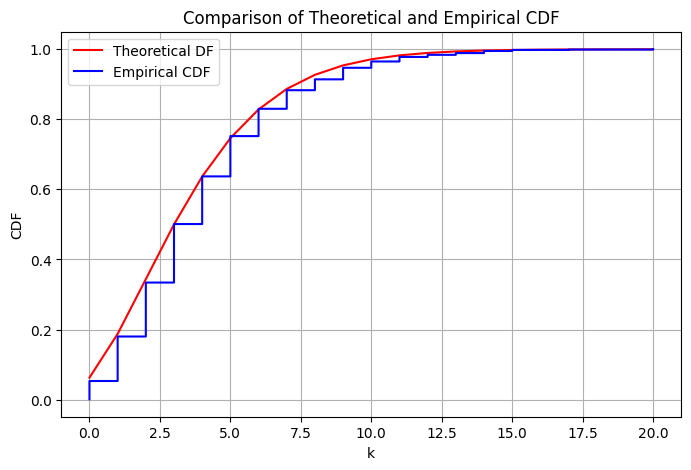

In [21]:
# Theoretical DF
df_theoretical = []
cumsum = 0
for k in range(k_max+1):
    cumsum += distribution(p, k)
    df_theoretical.append(cumsum)

k_values = list(range(k_max+1))

# Empirical CDF
sample_sorted = sorted(samples)
n = len(sample_sorted)
cdf_empirical = [(i+1)/n for i in range(n)]

plt.figure(figsize=(8,5))
plt.plot(k_values, df_theoretical, color='red', label='Theoretical DF')
plt.step(sample_sorted, cdf_empirical, where='post', color='blue', label='Empirical CDF')

plt.xlabel('k')
plt.ylabel('CDF')
plt.title('Comparison of Theoretical and Empirical CDF')
plt.legend()
plt.grid(True)
plt.show()